In [1]:
#LIBRERIAS
from pyspark.sql.functions import collect_list, concat_ws
from pyspark.sql.types import *

# ACTIVAR PYSPARK
from pyspark.sql import SparkSession
# LIBRERIAS
from pyspark.sql.functions import collect_list, concat_ws
from pyspark.sql.types import *
from pyspark.sql.functions import col
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import split
from pyspark.sql.functions import trim


#librerías gráficas
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def leerArchivoALinea(nombreArchivo):
    df = spark.read.csv(nombreArchivo, header=False)
    df = df.withColumn("line_number", monotonically_increasing_id())
    #df = df.withColumnRenamed("_c0", "coluna")
    return df.repartition(num_particiones)
# enddef

In [3]:
def generarIndice(df, separador= "     447"):
    #filtramos todas las filas que comienzan con el separador
    df_indiceFinal = df.filter(col("_c0").startswith(separador))
    #generamos un nuevo id para esos registros filtrados, este será nuestro id
    df_indiceFinal2 = df_indiceFinal.withColumn("id", monotonically_increasing_id())
    #
    df_indiceFinal2.createOrReplaceTempView("indice_view")
   
    df_index = spark.sql("""
            SELECT a.id, b.line_number as line_min, a.line_number as line_max
            FROM indice_view a
            JOIN indice_view b
            ON a.id = b.id+1
        """)
    return df_index    
#enddef

def filtrarRegistrosPorId(df_full, df_index, id_buscado):
    line_min = -1
    line_max = -1

    #filtramos desde el indice el id que nos interesa    
    df_index_selected = df_index.where(col("id")  == id_buscado)
    #traemos el grupo de registros 
    collected_data = df_index_selected.collect()
    #obtenemos los mínimos y máximos para filtrar desde df principal
    if collected_data and len(collected_data) > 0:
        line_min = collected_data[0].line_min
        line_max = collected_data[0].line_max
    #endif
        #filtramos los registros según el id buscado
    df_filtered = df_full.where((col("line_number") >= line_min) & (col("line_number") < line_max))
   
    #print("Para id=",id, " registros encontrados ", df_filtered.count())
    return df_filtered
#enddef

In [27]:
#se debe escoger los X átomos de iodo que los rodea a una distancia menor a Y, comenzar con X=6 e Y=4
def graficarAtomos(idAtomoPbEscogido = 1, cantidadAtomosI = 6, distanciaPbAIMAX = 4):

    #omitimos los dos registros que no nos interensan por el momento.
    df_registros_csv = df_filtrado.filter(~col("_c0").startswith("     447") & ~col("_c0").startswith(" i =    "))

    #ahora separamos los registros restantes para formar un csv
    split_df = df_registros_csv.withColumn("split_data", split(df_registros_csv["_c0"], "       "))
    
    #separamos en tipo, x, y z
    split_df = split_df.selectExpr("*", "split_data[0] as tipo", "split_data[1] as x", "split_data[2] as y", "split_data[3] as z")
    #quitamos los espacios extra originados en el split
    split_df = split_df.withColumn("tipo", trim(split_df["tipo"]))
    split_df = split_df.withColumn("x", trim(split_df["x"]))
    split_df = split_df.withColumn("y", trim(split_df["y"]))
    split_df = split_df.withColumn("z", trim(split_df["z"]))
    
    #ahora filtramos el tipo que nos interesa   
    atomo_PB = split_df.where(col("tipo") == "Pb")
    atomo_I = split_df.where(col("tipo") == "I")
    
    #agregamos un identificador único
    atomo_PB = atomo_PB.withColumn("ATOM_ID", monotonically_increasing_id())
    atomo_I  = atomo_I.withColumn("ATOM_ID", monotonically_increasing_id())
        
    atomo_PB.createOrReplaceTempView("ATOMO_PB")
    atomo_I.createOrReplaceTempView("ATOMO_I")    
    

    df_select = spark.sql(f"""
            SELECT sqrt(power(p.x - i.x,2) + power(p.y - i.y,2) + power(p.z - i.z,2)) distancia_eclidiana, 
            p.ATOM_ID,p.tipo, p.x as x1, p.y as y1, p.z as z1, 
            i.ATOM_ID as ATOM_ID_I, i.tipo as tipo_i, i.x as x2, i.y as y2, i.z as z2
            FROM ATOMO_PB p
            JOIN ATOMO_I i
            ON 1=1 
            where p.ATOM_ID = {idAtomoPbEscogido} and sqrt(power(p.x - i.x,2) + power(p.y - i.y,2) + power(p.z - i.z,2)) < {distanciaPbAIMAX}
            order by p.ATOM_ID, distancia_eclidiana 
                     
        """).limit(cantidadAtomosI)
    
    collected_data = df_select.collect()    
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    for row in collected_data:
        x1 = float(row.x1)
        y1 = float(row.y1)
        z1 = float(row.z1)
        x2 = float(row.x2)
        y2 = float(row.y2)
        z2 = float(row.z2)    
        #print(row.tipo, row.x1, row.y1, row.z1, "I:", row.tipo_i, row.x2, row.y2, row.z2)
        
        ax.plot([x1, x2], [y1, y2], [z1, z2])
        #colocamos los puntos
        ax.scatter(x1, y1, z1, c='green', marker='*', s=200)
        ax.scatter(x2, y2, z2, c='r', marker='o')    
        
        ax.text(x1, y1, z1, row.ATOM_ID, fontsize=12, color='red')
        ax.text(x2, y2, z2, row.ATOM_ID_I, fontsize=12, color='red')
    ax.set_title(f"Distancias de Átomos de Iodo al átomo {idAtomoPbEscogido} de Pb ")
   
    plt.show()
#enddef

In [5]:
spark = SparkSession.builder \
    .appName('Spark Process SQL') \
    .master('local[*]') \
    .getOrCreate()

num_particiones = 1

/home/davidcastro/anaconda3/envs/pyspark/lib/python3.6/site-packages/pyspark/context.py:238: FutureWarning: Python 3.6 support is deprecated in Spark 3.2.
  FutureWarning


Para id= 6  registros encontrados  449


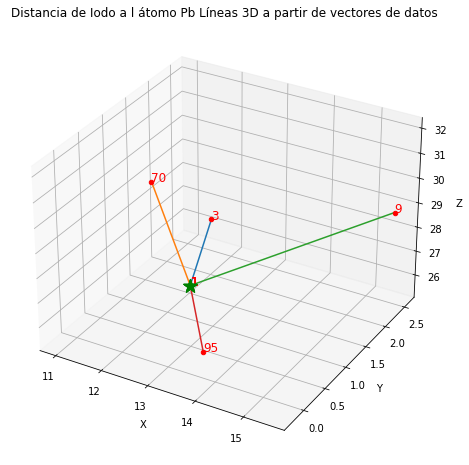

In [25]:
id = 6
df = leerArchivoALinea("data/a-i48000-min.xyz")
df_indice = generarIndice(df)
df_filtrado = filtrarRegistrosPorId(df, df_indice, id)
print("Para id=",id, " registros encontrados ", df_filtrado.count())

graficarAtomos(idAtomoPbEscogido = 1, cantidadAtomosI = 6, distanciaPbAIMAX = 4)

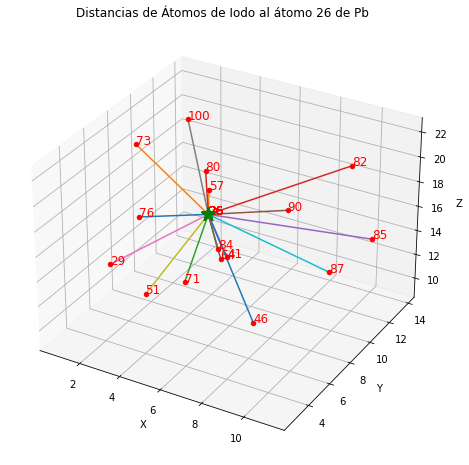

In [28]:
idAtomoPbEscogido = 26
cantidadAtomosI = 16 
distanciaPbAIMAX = 14
graficarAtomos(idAtomoPbEscogido, cantidadAtomosI, distanciaPbAIMAX)

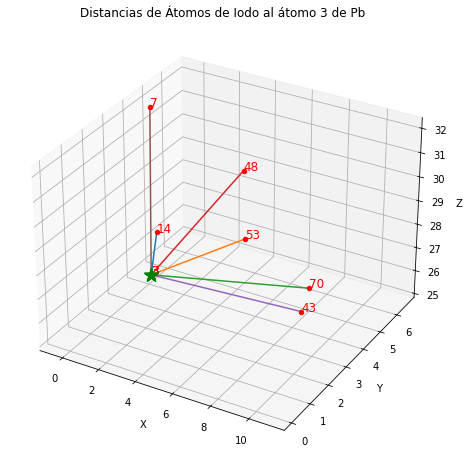

In [29]:
idAtomoPbEscogido = 3
cantidadAtomosI = 6 
distanciaPbAIMAX = 14
graficarAtomos(idAtomoPbEscogido, cantidadAtomosI, distanciaPbAIMAX)